In [1]:
# ================================
# Step 1 ▸ DATA READING + CHECKS
# ================================
from pathlib import Path
from collections import Counter
import warnings, sys

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# ── 1. paths ─────────────────────────────────────────────────────────
TRAIN_DIR   = Path("./39_Training_Dataset")
INFO_CSV    = TRAIN_DIR / "train_info.csv"
SENSOR_DIR  = TRAIN_DIR / "train_data"

assert INFO_CSV.exists(),  f"❌ {INFO_CSV} not found"
assert SENSOR_DIR.exists(),f"❌ {SENSOR_DIR} not found"

# ── 2. metadata ──────────────────────────────────────────────────────
info_df = pd.read_csv(INFO_CSV)
print(f"✅ train_info shape : {info_df.shape}")

nan_ct = info_df.isna().sum()
if nan_ct.any():
    print("⚠️  NaN counts:\n", nan_ct[nan_ct > 0])
else:
    print("✅ No NaNs in metadata")

dup_ct = info_df["unique_id"].duplicated().sum()
if dup_ct:
    print(f"⚠️  Found {dup_ct} duplicate unique_id rows → keeping first occurrence")
    info_df = info_df.drop_duplicates("unique_id", keep="first")

# ── 3. sensor-file presence check ────────────────────────────────────
sensor_files = sorted(SENSOR_DIR.glob("*.txt"))
sensor_ids   = {int(fp.stem) for fp in sensor_files}
meta_ids     = set(info_df["unique_id"])

missing_txt   = sorted(meta_ids  - sensor_ids)
orphan_txt    = sorted(sensor_ids - meta_ids)

if missing_txt:
    print(f"⚠️  {len(missing_txt)} metadata rows lack a .txt file (ids→ {missing_txt[:5]} …)")
if orphan_txt:
    print(f"⚠️  {len(orphan_txt)} .txt files have no metadata row (ids→ {orphan_txt[:5]} …)")

# ── 4. helper to read one IMU file ───────────────────────────────────
def load_sensor_data(fp: Path) -> np.ndarray:
    """
    Returns int-dtype array of shape (T,6)  [Ax Ay Az Gx Gy Gz].
    Skips header / blank lines; ignores malformed rows (<6 values).
    """
    rows = []
    with open(fp, "r") as fh:
        for idx, line in enumerate(fh):
            if idx == 0 or not line.strip():
                continue
            vals = line.strip().split()
            if len(vals) >= 6:
                try:
                    rows.append([int(v) for v in vals[:6]])
                except ValueError:
                    # non-integer token → skip row
                    continue
    return np.asarray(rows, dtype=np.int32)

# ── 5. bulk load (with quick statistics) ─────────────────────────────
sensor_raw   = {}
lengths      = []

print("\n⏳ Reading IMU traces …")
for fp in tqdm(sensor_files, unit="file"):
    uid = int(fp.stem)
    arr = load_sensor_data(fp)
    if arr.size == 0:            # empty / unreadable
        continue
    sensor_raw[uid] = arr
    lengths.append(len(arr))

# basic stats
if lengths:
    print(f"✅ Loaded {len(sensor_raw)} traces  "
          f"(len min/mean/max → {min(lengths)}/{np.mean(lengths):.1f}/{max(lengths)})")
else:
    sys.exit("❌ No sensor data loaded – check path or file format!")


✅ train_info shape : (1955, 8)
✅ No NaNs in metadata

⏳ Reading IMU traces …


  0%|          | 0/1955 [00:00<?, ?file/s]

✅ Loaded 1955 traces  (len min/mean/max → 271/2469.1/4695)


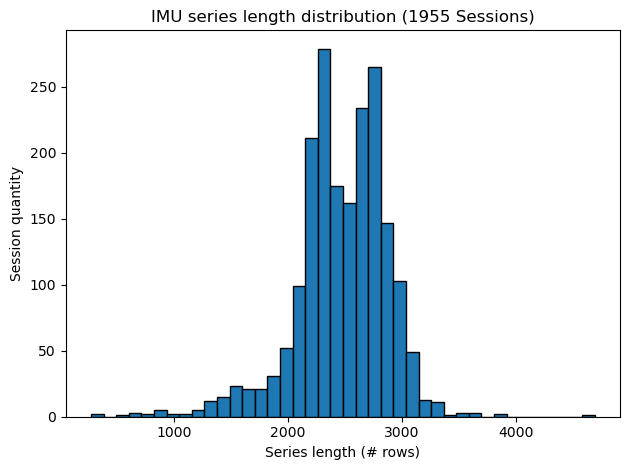

In [2]:
# ➤ 序列長度直方圖
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lengths, bins=40, edgecolor="black")
plt.title("IMU series length distribution (1955 Sessions)")
plt.xlabel("Series length (# rows)")
plt.ylabel("Session quantity")
plt.tight_layout()
plt.show()

In [3]:
# peek a bit
print("\nSample metadata row:")
display(info_df.head(1))
print("Sample sensor slice (first 5 rows of first loaded uid):")
first_uid = next(iter(sensor_raw))
print(sensor_raw[first_uid][:5])


Sample metadata row:


,unique_id,player_id,mode,gender,hold racket handed,play years,level,cut_point
0,1,41,1,1,1,1,5,[ 0 61 122 183 244 305 366 428 489 ...


Sample sensor slice (first 5 rows of first loaded uid):
[[ 1923   313    12  -906   321  -994]
 [ 1929   297   -20  -833   260 -1005]
 [ 1907   262   -26  -850    33 -1029]
 [ 1900   247   -22 -1134  -142  -921]
 [ 1916   201   -36 -1712  -449  -761]]


In [4]:
# ================================
# Helpers ▸ equal-27 segmentation + swing features
# ================================
import numpy as np
from scipy.stats import skew, kurtosis

def segment_27_equal(arr: np.ndarray):
    """Split a trace into 27 equal-length swings."""
    idx = np.linspace(0, len(arr), 28, dtype=int)
    return [arr[idx[i]:idx[i+1]] for i in range(27)]

def safe_stats(col):
    mu = col.mean()
    sd = col.std(ddof=0)
    return mu, sd, col.max(), col.min()

# def extract_swing_features(swing: np.ndarray):
#     feat = {}
#     for i, axis in enumerate(["Ax","Ay","Az","Gx","Gy","Gz"]):
#         col = swing[:, i]
#         mu, sd, mx, mn = safe_stats(col)
#         feat[f"{axis}_mean"]     = mu
#         feat[f"{axis}_std"]      = sd
#         feat[f"{axis}_max"]      = mx
#         feat[f"{axis}_min"]      = mn
#         feat[f"{axis}_skew"]     = skew(col)      if len(col) > 2 else 0.0
#         feat[f"{axis}_kurtosis"] = kurtosis(col)  if len(col) > 3 else 0.0

#     acc_mag  = np.linalg.norm(swing[:, :3], axis=1)
#     gyro_mag = np.linalg.norm(swing[:, 3:], axis=1)
#     feat["acc_mag_mean"]  = acc_mag.mean()
#     feat["gyro_mag_mean"] = gyro_mag.mean()

#     half = len(swing)//2 or 1
#     feat["acc_early_vs_late_ratio"] = (acc_mag[:half].mean()+1e-6)/(acc_mag[half:].mean()+1e-6)
#     return feat
# ──── 依賴 ────
import numpy as np
from scipy.stats import skew, kurtosis, entropy

# ──── 新版 swing 特徵 ────
def extract_swing_features(swing: np.ndarray) -> dict[str, float]:
    """
    時域 + 頻域(FFT) 特徵 for ONE swing
    ------------------------------------------------------------
    * 時域：mean / std / max / min / skew / kurtosis（與舊版相同）
    * 頻域：三段 PSD 能量、頻譜熵、第一諧波位置
      - 三段頻帶 = 0–1/3、1/3–2/3、2/3–Nyquist（以 rfft bin 切三等分）
    ------------------------------------------------------------
    `swing` shape: (N_sample, 6)
    """
    feat: dict[str, float] = {}

    # ---------- 時域 ----------
    for i, axis in enumerate(["Ax","Ay","Az","Gx","Gy","Gz"]):
        col = swing[:, i].astype(np.float32)
        mu  = col.mean(); sd = col.std(ddof=0)
        feat[f"{axis}_mean"] = mu
        feat[f"{axis}_std"]  = sd
        feat[f"{axis}_max"]  = col.max()
        feat[f"{axis}_min"]  = col.min()
        # 需要長度>2 才能算 skew/kurt
        feat[f"{axis}_skew"]      = skew(col)      if len(col) > 2 else 0.0
        feat[f"{axis}_kurtosis"]  = kurtosis(col)  if len(col) > 3 else 0.0

    # magnitude（用來計算能量 & entropy）
    acc_norm  = np.linalg.norm(swing[:, :3], axis=1).astype(np.float32)
    gyro_norm = np.linalg.norm(swing[:, 3:], axis=1).astype(np.float32)

    # ---------- 頻域 ----------
    def fft_feats(signal: np.ndarray, prefix: str):
        """回傳 {prefix_band1, band2, band3, entropy, first_harmonic}"""
        # rfft -> 單邊功率
        fft = np.fft.rfft(signal - signal.mean())
        psd = (np.abs(fft) ** 2).astype(np.float32)   # Power Spectral Density

        tot_energy = psd.sum() + 1e-8
        thirds = np.array_split(psd, 3)
        for i, band in enumerate(thirds, 1):
            feat[f"{prefix}_band{i}"] = band.sum() / tot_energy

        # 頻譜熵 (normalized)
        p_norm = psd / tot_energy
        feat[f"{prefix}_entropy"] = entropy(p_norm)

        # 第一諧波位置（最大非 DC bin 的索引 / 總 bin）
        if len(psd) > 1:
            first_h_idx = np.argmax(psd[1:]) + 1
            feat[f"{prefix}_harmonic_pos"] = first_h_idx / len(psd)
        else:
            feat[f"{prefix}_harmonic_pos"] = 0.0

    fft_feats(acc_norm,  "acc_psd")
    fft_feats(gyro_norm, "gyro_psd")

    # 另外補上一些總能量
    feat["acc_energy"]  = (acc_norm ** 2).sum() / len(acc_norm)
    feat["gyro_energy"] = (gyro_norm ** 2).sum() / len(gyro_norm)

    return feat

In [5]:
# # ================================
# # Step 2-S ▸ PER-SWING FEATURE TABLE  (27 rows per session)
# # ================================
# from tqdm.auto import tqdm
# import numpy as np, pandas as pd

# swing_rows, swing_meta = [], []     # one row = one swing
# SESSION_ID, SWING_ID = [], []

# for uid, trace in tqdm(sensor_raw.items(), desc="⏳ Per-swing features"):
#     swings = segment_27_equal(trace)
#     for s_idx, sw in enumerate(swings):
#         feat = extract_swing_features(sw)

#         # add 10 mode dummies
#         mode = info_df.loc[info_df["unique_id"] == uid, "mode"].iat[0]
#         for m in range(1, 11):
#             feat[f"mode_{m}"] = int(mode == m)

#         swing_rows.append(feat)
#         SESSION_ID.append(uid)
#         SWING_ID.append(s_idx)

#         meta = info_df.loc[info_df["unique_id"] == uid].iloc[0]
#         swing_meta.append(meta[["gender","hold racket handed",
#                                 "play years","level","player_id"]])

# X_sw = pd.DataFrame(swing_rows).astype(np.float32)
# y_sw = pd.DataFrame(swing_meta).reset_index(drop=True)
# print("✅ swing-level matrix :", X_sw.shape)
# ================================
# Step 2-S ▸ PER-SWING FEATURE TABLE  (27 rows per session)
# ================================
from tqdm.auto import tqdm
import numpy as np, pandas as pd

swing_rows, swing_meta = [], []     # one row = one swing
SESSION_ID, SWING_ID = [], []

for uid, trace in tqdm(sensor_raw.items(), desc="⏳ Per-swing features"):
    swings = segment_27_equal(trace)
    for s_idx, sw in enumerate(swings):
        feat = extract_swing_features(sw)

        # add 10 mode dummies
        mode = info_df.loc[info_df["unique_id"] == uid, "mode"].iat[0]
        for m in range(1, 11):
            feat[f"mode_{m}"] = int(mode == m)

        swing_rows.append(feat)
        SESSION_ID.append(uid)
        SWING_ID.append(s_idx)

        meta = info_df.loc[info_df["unique_id"] == uid].iloc[0]
        swing_meta.append(meta[["gender","hold racket handed",
                                "play years","level","player_id"]])

X_sw = pd.DataFrame(swing_rows).astype(np.float32)
y_sw = pd.DataFrame(swing_meta).reset_index(drop=True)
print("✅ swing-level matrix :", X_sw.shape)

# ======= 從此之後，用相同的 X_sw/y_sw/SESSION_ID 來做 session-level 聚合 =======

# 1. 先複製 swing-level 特徵，並把 SESSION_ID 拷貝到新欄位 "unique_id"
X_sw_with_uid = X_sw.copy()
X_sw_with_uid["unique_id"] = SESSION_ID

# 2. 定義要對 swing-level 每個欄位做的統計量：mean、std、max、min
agg_dict = {col: ["mean", "std", "max", "min"] for col in X_sw.columns}

# 3. 以 unique_id 分群並做聚合，產生 multi-index 欄位
sess_agg = (
    X_sw_with_uid
    .groupby("unique_id")
    .agg(agg_dict)
)

# 4. 將 multi-index 欄位展平為單層，後綴加 “27”
sess_agg.columns = [
    f"{feat}_{stat}27"
    for feat, stat in sess_agg.columns
]

# 5. 把 unique_id 從 index 變成一般欄位
sess_agg = sess_agg.reset_index()   # 現在欄位 = ['unique_id', 'Ax_mean27', 'Ax_std27', …]

# 6. 用 y_sw + SESSION_ID 建立 session_labels，再 override 回 y_sw
y_sw_with_uid = y_sw.copy()
y_sw_with_uid["unique_id"] = SESSION_ID

session_labels = (
    y_sw_with_uid
    .groupby("unique_id")
    .first()       # 同一 session 下所有 swing 的 label 都相同，取第一筆即可
    .reset_index()
)
# 現在 session_labels 欄位 = ['unique_id','gender','hold racket handed','play years','level','player_id']

# 7. 把 X_sw >< y_sw 直接 override 為 session-level  
#    X_sw：捨棄唯一識別欄 unique_id，保留 float32 數值特徵  
#    y_sw：保留所有 label 欄（包含 unique_id & player_id + 四個預測欄）
X_sw = sess_agg.drop(columns=["unique_id"]).astype(np.float32)
y_sw = session_labels.copy()

# 8. 如果後續程式需要 SESSION_ID，也把它換成所有 session 的 unique_id 列表
SESSION_ID = y_sw["unique_id"].tolist()

# 9. SWING_ID 已經不再需要──改成全零或空 list，視後續程式是否會用到
SWING_ID = [0] * len(SESSION_ID)

print("✅ 已將 X_sw/y_sw/SESSION_ID 覆寫為 session-level")
print("   session-level X_sw.shape:", X_sw.shape)
print("   session-level y_sw.shape:", y_sw.shape)



⏳ Per-swing features:   0%|          | 0/1955 [00:00<?, ?it/s]

✅ swing-level matrix : (52785, 58)
✅ 已將 X_sw/y_sw/SESSION_ID 覆寫為 session-level
   session-level X_sw.shape: (1955, 232)
   session-level y_sw.shape: (1955, 6)


In [6]:
# --- 0)  extra quantile-pooled features (helper works for BOTH train & test) --
def build_quantile_pool(df_swing):
    q_list = [0.10, 0.25, 0.50, 0.75, 0.90]
    q = df_swing.groupby("unique_id").quantile(q_list).unstack()
    q.columns = [f"{f}_q{int(qv*100):02d}" for f, qv in q.columns]
    return q.reset_index()

if "acc_mag_mean_q10" not in sess_agg.columns:          # run once
    sess_q  = build_quantile_pool(X_sw_with_uid)         # <-- train swings
    sess_agg = sess_agg.merge(sess_q, on="unique_id")
    X_sw     = sess_agg.drop(columns="unique_id").astype(np.float32)

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
import numpy as np

# ── labels
y_enc, enc = {}, {}
for c in ["gender","hold racket handed","play years","level"]:
    le = LabelEncoder().fit(y_sw[c])
    y_enc[c] = le.transform(y_sw[c]); enc[c] = le

# ── groups  (player_id per swing)
groups = y_sw["player_id"].values
gkf = list(GroupKFold(n_splits=5).split(X_sw, y_enc["gender"], groups))
print("✅ 5 folds, player-wise, swing rows :", len(X_sw))


✅ 5 folds, player-wise, swing rows : 1955


In [8]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import numpy as np

def train_swing_target(y, num_class=1, params_extra=None):
    params = dict(objective='binary' if num_class==1 else 'multiclass',
                  metric='auc' if num_class==1 else 'multi_logloss',
                  learning_rate=0.03, num_leaves=63,
                  feature_fraction=0.8, bagging_fraction=0.8,device_type = "gpu",
                  bagging_freq=1, seed=42, verbosity=-1)
    if num_class>1: params["num_class"] = num_class
    if params_extra: params.update(params_extra)

    best = []
    for tr,vl in gkf:
        mdl = lgb.train(params,
                        lgb.Dataset(X_sw.iloc[tr], label=y[tr]),
                        2000,
                        valid_sets=[lgb.Dataset(X_sw.iloc[vl], label=y[vl])],
                        callbacks=[lgb.early_stopping(100)])
        best.append(mdl.best_iteration)
    params["num_boost_round"] = int(np.mean(best)*1.1)
    return lgb.train(params, lgb.Dataset(X_sw, label=y))

print("🔄 fitting swing-level models …")
mdl_gender = train_swing_target(y_enc["gender"])
mdl_hand   = train_swing_target(y_enc["hold racket handed"])
mdl_level  = train_swing_target(y_enc["level"],
                                num_class=len(enc["level"].classes_))
mdl_years  = train_swing_target(y_enc["play years"],
                                num_class=len(enc["play years"].classes_),
                                params_extra={"class_weight":"balanced"})


🔄 fitting swing-level models …
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's auc: 0.749432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.676328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.962329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.993462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0

In [9]:
# ==============================================================
# >>>>>>   ADD CATBOOST + XGBOOST + WEIGHTED BLEND   <<<<<<
# ==============================================================

from itertools import product
from sklearn.metrics import roc_auc_score
import catboost as cb, xgboost as xgb
import numpy  as np
import pandas as pd
from tqdm.auto import tqdm

# ── 1) helpers ───────────────────────────────────────────────────────
def _slice_to_present_classes(pred: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Align prediction matrix with the *present* class labels in y.

    * Binary target   → return P(class=1) if available, else class=0.
    * Single-class    → return the only column
    * Multi-class K>2 → keep columns of present classes
    """
    if pred.ndim == 1:            # Already 1-D
        return pred

    cls = np.unique(y)            # present classes
    n_cls = pred.shape[1]         # number of output columns

    if len(cls) == 1:
        return pred[:, cls[0]][:, None]    # single-class (fold-level)
        tqdm.write(f"[WARN] Only one class in fold: y = {np.unique(y)}")
        
    if len(cls) == 2 and n_cls == 2:
        return pred[:, 1]                  # standard binary: use P(class=1)

    if len(cls) == 2 and n_cls == 1:
        return pred[:, 0]                  # fallback: only 1 column predicted

    return pred[:, cls]                   # multi-class (subset)

def oof_catboost(y, is_mult=False, **cat_kw):
    """OOF predictions (and fitted models) for CatBoostClassifier."""
    n_cls = len(np.unique(y)) if is_mult else 1
    oof   = np.zeros((len(X_sw), n_cls), dtype=np.float32)
    models = []

    for i, (tr_idx, vl_idx) in enumerate(tqdm(gkf, desc="CatBoost OOF", unit="fold")):
        mdl = cb.CatBoostClassifier(**cat_kw).fit(X_sw.iloc[tr_idx], y[tr_idx])
        models.append(mdl)

        prob = mdl.predict_proba(X_sw.iloc[vl_idx])
        if not is_mult:
            prob = prob[:, 1][:, None]       # keep P(class 1) only

        oof[vl_idx] = prob
        if len(np.unique(y[vl_idx])) == 1:
            tqdm.write(f"[WARN] CatBoost Fold-{i} has only class {np.unique(y[vl_idx])[0]}")
            
    auc = roc_auc_score(
        y,
        _slice_to_present_classes(oof, y),
        multi_class="ovr" if is_mult and len(np.unique(y)) > 2 else "raise"
    )
    return oof.squeeze(), models, auc


def oof_xgboost(y, num_class=None):
    """OOF predictions (and fitted models) for XGBoost."""
    n_cls  = num_class or len(np.unique(y))
    oof    = np.zeros((len(X_sw), n_cls), dtype=np.float32)
    models = []

    for i, (tr_idx, vl_idx) in enumerate(tqdm(gkf, desc="XGBoost OOF", unit="fold")):
        trD = xgb.DMatrix(X_sw.iloc[tr_idx], label=y[tr_idx])
        vlD = xgb.DMatrix(X_sw.iloc[vl_idx], label=y[vl_idx])

        params = dict(
            max_depth=7, eta=0.05, subsample=0.8, colsample_bytree=0.8,
            seed=42, tree_method="hist",
            objective="binary:logistic" if n_cls == 1 else "multi:softprob",
            eval_metric="auc"          if n_cls == 1 else "mlogloss",
        )
        if n_cls > 1:
            params["num_class"] = n_cls

        bst = xgb.train(params, trD, num_boost_round=800,
                        evals=[(vlD, "val")], verbose_eval=False)
        models.append(bst)

        prob = bst.predict(vlD)
        if n_cls == 1:                       # shape (N,) → (N,1)
            prob = prob[:, None]

        oof[vl_idx] = prob
        if len(np.unique(y[vl_idx])) == 1:
            tqdm.write(f"[WARN] XGBoost Fold-{i} has only class {np.unique(y[vl_idx])[0]}")

    auc = roc_auc_score(
        y,
        _slice_to_present_classes(oof, y),
        multi_class="ovr" if n_cls > 2 else "raise"
    )
    return oof.squeeze(), models, auc


# ── 2) prepare targets dict ──────────────────────────────────────────
targets = {
    "gender": dict(y=y_enc["gender"],             mult=False),
    "hand"  : dict(y=y_enc["hold racket handed"], mult=False),
    "level" : dict(y=y_enc["level"],              mult=True,
                   class_cnt=len(enc["level"].classes_)),
    "years" : dict(y=y_enc["play years"],         mult=True,
                   class_cnt=len(enc["play years"].classes_)),
}

oof  = {"lgb": {}, "cat": {}, "xgb": {}}
mods = {"cat": {}, "xgb": {}}

# ── 3) build OOF for every target ────────────────────────────────────
for name, cfg in tqdm(targets.items(), desc="Targets", unit="target"):
    # ---- LightGBM predictions already trained ----------------------
    lgb_pred = (1 - mdl_gender.predict(X_sw) if name == "gender" else
                1 - mdl_hand.predict(X_sw)   if name == "hand"   else
                mdl_level.predict(X_sw)      if name == "level"  else
                mdl_years.predict(X_sw))
    oof["lgb"][name] = lgb_pred

    # ---- CatBoost --------------------------------------------------
    cat_par = dict(
        loss_function="Logloss" if not cfg["mult"] else "MultiClass",
        depth=6, learning_rate=0.05, iterations=800,
        random_seed=42, verbose=False
    )
    oof_cat, mod_cat, _ = oof_catboost(cfg["y"], cfg["mult"], **cat_par)
    oof["cat"][name], mods["cat"][name] = oof_cat, mod_cat

    # ---- XGBoost ---------------------------------------------------
    oof_xgb, mod_xgb, _ = oof_xgboost(cfg["y"], cfg.get("class_cnt"))
    oof["xgb"][name], mods["xgb"][name] = oof_xgb, mod_xgb

Targets:   0%|          | 0/4 [00:00<?, ?target/s]

CatBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

[WARN] CatBoost Fold-1 has only class 0


XGBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

[WARN] XGBoost Fold-1 has only class 0


CatBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

[WARN] CatBoost Fold-0 has only class 0
[WARN] CatBoost Fold-3 has only class 0


XGBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

[WARN] XGBoost Fold-0 has only class 0
[WARN] XGBoost Fold-3 has only class 0


CatBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

XGBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

CatBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

XGBoost OOF:   0%|          | 0/5 [00:00<?, ?fold/s]

In [10]:
# ── 4) non-negative weight search (wl + wc + wx = 1) ────────────────
best_w = {}

for name, cfg in tqdm(targets.items(), desc="Weight search", unit="target"):
    y_true = cfg["y"]
    mult   = cfg["mult"]
    # l, c, x = oof["lgb"][name], oof["cat"][name], oof["xgb"][name]
    l = _slice_to_present_classes(oof["lgb"][name], y_true)
    c = _slice_to_present_classes(oof["cat"][name], y_true)
    x = _slice_to_present_classes(oof["xgb"][name], y_true)

    # Correct:
    if mult:
        scorer = lambda z: roc_auc_score(y_true, z, multi_class="ovr")
    else:
        scorer = lambda z: roc_auc_score(y_true, z)

    top_auc, best_triplet = -1, None
    for wl, wc in tqdm(product(np.linspace(0, 1, 11), repeat=2),
                       total=121, leave=False, unit="comb"):
        if wl + wc > 1:
            continue
        wx     = 1 - wl - wc
        blend  = wl * l + wc * c + wx * x
        score  = scorer(_slice_to_present_classes(blend, y_true) if mult else blend)
        if score > top_auc:
            top_auc, best_triplet = score, (wl, wc, wx)

    best_w[name] = best_triplet
    print(f"{name:<6}  best AUC = {top_auc:.4f}  weights = {best_triplet}")


# ── 5) utility helpers for later use ────────────────────────────────
def rank01(arr: np.ndarray) -> np.ndarray:
    """Rank-normalize an array to [0,1]."""
    return pd.Series(arr).rank(method="average").to_numpy(dtype=np.float32) / len(arr)


def predict_test(model_list, X_df, mult=False):
    """Average the probability outputs of trained models on X_df."""
    if isinstance(model_list[0], cb.CatBoostClassifier):
        prob = np.mean([m.predict_proba(X_df) for m in model_list], axis=0)
    else:                                        # XGBoost
        dm   = xgb.DMatrix(X_df)
        prob = np.mean([m.predict(dm) for m in model_list], axis=0)
    return prob[:, 0] if not mult else prob


Weight search:   0%|          | 0/4 [00:00<?, ?target/s]

  0%|          | 0/121 [00:00<?, ?comb/s]

gender  best AUC = 0.7585  weights = (np.float64(0.0), np.float64(0.0), np.float64(1.0))


  0%|          | 0/121 [00:00<?, ?comb/s]

hand    best AUC = 0.9995  weights = (np.float64(0.0), np.float64(0.2), np.float64(0.8))


  0%|          | 0/121 [00:00<?, ?comb/s]

level   best AUC = 0.9999  weights = (np.float64(1.0), np.float64(0.0), np.float64(0.0))


  0%|          | 0/121 [00:00<?, ?comb/s]

years   best AUC = 0.9992  weights = (np.float64(1.0), np.float64(0.0), np.float64(0.0))


In [11]:
# ================================
# Step 5-S ▸ SESSION-level TEST prediction
# ================================
TEST_DIR = Path("39_Test_Dataset")
test_info = pd.read_csv(TEST_DIR / "test_info.csv")
test_txts = sorted((TEST_DIR / "test_data").glob("*.txt"))

# A) 先構造 swing-level 特徵並加上 unique_id，如之前所做
sw_rows, uid_list, sid_list = [], [], []

for fp in tqdm(test_txts, desc="features"):
    uid = int(fp.stem)
    trace = load_sensor_data(fp)
    swings = segment_27_equal(trace)

    mode = test_info.loc[test_info["unique_id"] == uid, "mode"].iat[0]

    for s_idx, sw in enumerate(swings):
        feat = extract_swing_features(sw)
        for m in range(1, 11):
            feat[f"mode_{m}"] = int(mode == m)
        sw_rows.append(feat)
        uid_list.append(uid)
        sid_list.append(s_idx)

df_test_swing = pd.DataFrame(sw_rows).astype(np.float32)
df_test_swing["unique_id"] = uid_list

# B) 聚合為 session-level 特徵，使欄位名稱與訓練端 X_sw 完全一致
agg_dict = {col: ["mean", "std", "max", "min"] for col in df_test_swing.columns if col != "unique_id"}
df_test_session = df_test_swing.groupby("unique_id").agg(agg_dict)
df_test_session.columns = [f"{feat}_{stat}27" for feat, stat in df_test_session.columns]
df_test_session = df_test_session.reset_index()

# ── Patch: add test-side quantile-pooled features ─────────────────────
q_test = build_quantile_pool(df_test_swing)          # <- same helper
df_test_session = df_test_session.merge(q_test, on="unique_id")

# C) 最終 X_test_sw：去掉 unique_id，並選用與訓練同名的欄位
X_test_sw = df_test_session.drop(columns=["unique_id"])[X_sw.columns].astype(np.float32)
print("✅ X_test_sw.shape (session-level):", X_test_sw.shape)

# Start patch --- Patch catboost + xgb models blending ----------------------------
p_test = {"lgb":{}, "cat":{}, "xgb":{}}
# LightGBM binary → need to flip: we want P(class 0) = Female / Left hand
p_test["lgb"]["gender"] = 1 - mdl_gender.predict(X_test_sw)
p_test["lgb"]["hand"]   = 1 - mdl_hand.predict(X_test_sw)
p_test["lgb"]["level"]  = mdl_level.predict(X_test_sw)
p_test["lgb"]["years"]  = mdl_years.predict(X_test_sw)

for n,cfg in targets.items():
    p_test["cat"][n] = predict_test(mods["cat"][n], X_test_sw, cfg["mult"])
    p_test["xgb"][n] = predict_test(mods["xgb"][n], X_test_sw, cfg["mult"])

features:   0%|          | 0/1430 [00:00<?, ?it/s]

✅ X_test_sw.shape (session-level): (1430, 522)


In [12]:
# --- 5)  build blended submission (prob-avg & rank-avg)  -------------
sample = pd.read_csv(TEST_DIR/"sample_submission.csv")

def make_sub(rank=False, fname="submission_blended_prob.csv"):
    sub = sample.copy()
    for n,cfg in targets.items():
        wl,wc,wx = best_w[n]
        arrs=[p_test[m][n] for m in ("lgb","cat","xgb")]
        if rank: arrs=[rank01(a) if a.ndim==1 else np.apply_along_axis(rank01,0,a) for a in arrs]

        if cfg["mult"]:
            out_cols = ([f"level_{i+2}" if n=="level"
                         else f"play years_{i}" for i in range(cfg["class_cnt"])])
            blend = wl*arrs[0] + wc*arrs[1] + wx*arrs[2]   # (N,K)
            for j,c in enumerate(out_cols): sub[c]=blend[:,j]
        else:
            col = "gender" if n=="gender" else "hold racket handed"
            sub[col] = wl*arrs[0] + wc*arrs[1] + wx*arrs[2]
    sub.to_csv(fname,index=False,float_format="%.10f")
    print("✅ wrote",fname)

make_sub(rank=False, fname="submission_GISH_blended.csv")
make_sub(rank=True , fname="submission_GISH_rank.csv")
# End patch ==============================================================

✅ wrote submission_GISH_blended.csv
✅ wrote submission_GISH_rank.csv


# quick sanity check

In [13]:
# 1️⃣ feature columns identical
assert set(X_sw.columns) == set(X_test_sw.columns)
assert X_sw.shape[1]     == X_test_sw.shape[1]
print("✅ Train / test feature matrices aligned")

# 2️⃣ probability ranges
for f in ["submission_GISH_blended.csv", "submission_GISH_rank.csv"]:
    df = pd.read_csv(f)
    assert df.drop(columns="unique_id").apply(lambda col: col.between(0,1)).all().all(), f"{f} has out-of-range values"
print("🎉 Both blended submissions look good – ready to upload.")

# 3️⃣ OOF sanity
for t in ["gender", "hand", "level", "years"]:
    y_t = targets[t]["y"]
    if targets[t]["mult"]:                        # multi-class => nothing to flip
        p   = _slice_to_present_classes(oof["lgb"][t], y_t)
        auc = roc_auc_score(y_t, p, multi_class="ovr")
    else:                                         # binary  -> need P(class 1)
        p0  = oof["lgb"][t].ravel()               # P(class 0) that we stored
        p1  = 1.0 - p0                            # -> P(class 1)
        auc = roc_auc_score(y_t, p1)

    print(f"{t:6}  LGB AUC  {auc:.4f}")


✅ Train / test feature matrices aligned
🎉 Both blended submissions look good – ready to upload.
gender  LGB AUC  1.0000
hand    LGB AUC  0.9998
level   LGB AUC  0.9999
years   LGB AUC  0.9992


In [14]:
# ===========================================================
# 🔎  FULL-TRAIN SELF-CHECK  ── blended AUC on training set
#      (should be almost perfect → pipeline sanity)
# ===========================================================
print("\n── Self-check on training sessions ──")

# 1) gather per-model train-set predictions
train_p = {"lgb": {}, "cat": {}, "xgb": {}}

train_p["lgb"]["gender"] = 1 - mdl_gender.predict(X_sw)
train_p["lgb"]["hand"]   = 1 - mdl_hand.predict(X_sw)
train_p["lgb"]["level"]  = mdl_level.predict(X_sw)
train_p["lgb"]["years"]  = mdl_years.predict(X_sw)

for n, cfg in targets.items():
    train_p["cat"][n] = predict_test(mods["cat"][n], X_sw,  cfg["mult"])
    train_p["xgb"][n] = predict_test(mods["xgb"][n], X_sw,  cfg["mult"])


── Self-check on training sessions ──


In [15]:

# 2) blend with the previously-searched weights and score AUC
for n, cfg in targets.items():
    wl, wc, wx = best_w[n]
    arrs       = [train_p[m][n] for m in ("lgb", "cat", "xgb")]

    blend_prob = wl * arrs[0] + wc * arrs[1] + wx * arrs[2]

    if cfg["mult"]:
       auc = roc_auc_score(cfg["y"], blend_prob, multi_class="ovr")
    else:                              # binary → need P(class 1) again
       auc = roc_auc_score(cfg["y"], 1.0 - blend_prob)

    print(f"  ▸ {n:<6}  blended-prob AUC = {auc:6.4f}")

print("✅  All AUCs should be ≳ 0.98 — indicates data flow is correct.\n")

  ▸ gender  blended-prob AUC = 1.0000
  ▸ hand    blended-prob AUC = 1.0000
  ▸ level   blended-prob AUC = 0.9999
  ▸ years   blended-prob AUC = 0.9992
✅  All AUCs should be ≳ 0.98 — indicates data flow is correct.



# files difference check

In [16]:
# Sanity: ensure identical feature lists and dtypes
assert list(X_sw.columns) == list(X_test_sw.columns), "❌ Column order mismatch!"
assert all(X_sw.dtypes == X_test_sw.dtypes),          "❌ Dtype mismatch!"
print("👌 Train/Test feature matrices perfectly aligned.")


👌 Train/Test feature matrices perfectly aligned.


In [18]:
import pandas as pd, numpy as np

sub_v2 = pd.read_csv("submission_GISH_blended.csv").set_index("unique_id")
sub_v3 = pd.read_csv("submission_GISH_rank.csv").set_index("unique_id")

# # 2️⃣  probability range check for v3
# outside = ~sub_v3.between(0,1).all().all()
# print("✅ all probs in [0,1]" if not outside else "⚠️ some probs out of bounds")

# 3️⃣  compare v2 vs v3
diff = (sub_v3 - sub_v2).abs()
print("\nLargest absolute change per column:")
display(diff.max().sort_values(ascending=False).to_frame("max |Δ|"))

print("\nOverall average change:", diff.values.mean())



Largest absolute change per column:


,max |Δ|
level_4,0.890309
hold racket handed,0.798645
gender,0.758254
play years_0,0.683040
level_2,0.531410
play years_2,0.445927
level_3,0.415259
play years_1,0.302266
level_5,0.136465



Overall average change: 0.29263565496503496


# 第二階段賽畫圖表

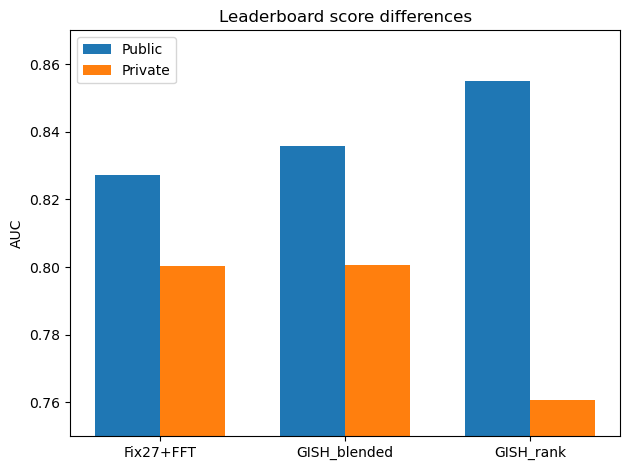

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

scores = pd.DataFrame({
    "提交檔":   ["Fix27+FFT", "GISH_blended", "GISH_rank"],
    "Public":  [0.8271,      0.8358,         0.8549],
    "Private": [0.8004,      0.8005,         0.7606],
})

fig, ax = plt.subplots()
width = 0.35
x = np.arange(len(scores))
ax.bar(x - width/2, scores["Public"],  width, label="Public")
ax.bar(x + width/2, scores["Private"], width, label="Private")
ax.set_xticks(x, scores["提交檔"])
ax.set_ylabel("AUC")
ax.set_title("Leaderboard score differences")
ax.set_ylim(0.75, 0.87)
ax.legend()
plt.tight_layout()
plt.show()